In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/margot-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/obama-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/musk-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-musk.wav
/kaggle/input/deep-voice-deepfake-

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Masking


# **Data Preprocessing**

In [3]:

data_directory = '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO'  
real_paths = []
fake_paths = []

real_directory = os.path.join(data_directory, 'REAL')  
fake_directory = os.path.join(data_directory, 'FAKE')  

for filename in os.listdir(real_directory):
    if 'original' in filename:  
        real_paths.append(os.path.join(real_directory, filename))

for filename in os.listdir(fake_directory):
    if 'to' in filename:  
        fake_paths.append(os.path.join(fake_directory, filename))

def load_and_preprocess_data(audio_path, label):
    audio, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return mfccs.T, label

def prepare_dataset(real_paths, fake_paths):
    X, y = [], []
    
    for path in real_paths:
        features, label = load_and_preprocess_data(path, 0)
        X.append(features)
        y.append(label)
    
    for path in fake_paths:
        features, label = load_and_preprocess_data(path, 1)
        X.append(features)
        y.append(label)
    
    return X, np.array(y)

X, y = prepare_dataset(real_paths, fake_paths)

In [4]:
print("Number of real audio samples:", len(real_paths))
print("Number of fake audio samples:", len(fake_paths))

Number of real audio samples: 8
Number of fake audio samples: 56


In [5]:
def augment_data(X, y):
    augmented_X, augmented_y = [], []
    
    for features, label in zip(X, y):
        augmented_X.append(features)
        augmented_y.append(label)
        
        audio_signal = librosa.effects.time_stretch(features.T[0], rate=0.8)  # Simulate on audio signal
        augmented_X.append(librosa.feature.mfcc(y=audio_signal, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)
        
        audio_signal_shifted = librosa.effects.pitch_shift(features.T[0], sr=22050, n_steps=2)
        augmented_X.append(librosa.feature.mfcc(y=audio_signal_shifted, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)
    
    return augmented_X, np.array(augmented_y)


# **Data Visualization**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


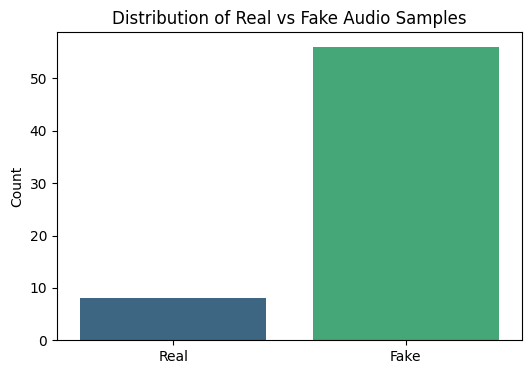

In [6]:
real_count = len(real_paths)  
fake_count = len(fake_paths)

plt.figure(figsize=(6, 4))
sns.barplot(x=['Real', 'Fake'], y=[real_count, fake_count], palette="viridis")
plt.title('Distribution of Real vs Fake Audio Samples')
plt.ylabel('Count')
plt.show()

Real Audio Spectogram


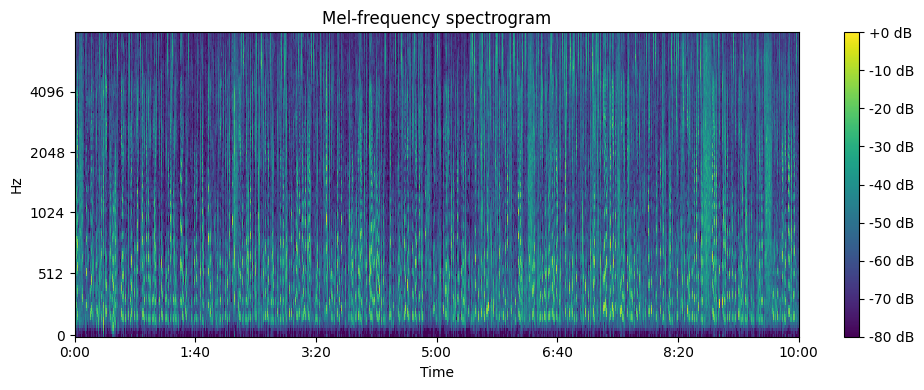

Fake Audio Spectogram


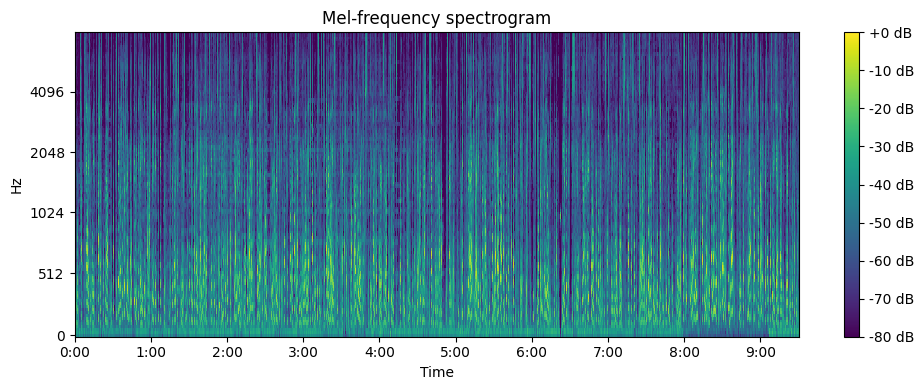

In [7]:
def plot_spectrogram(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    log_S = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

print('Real Audio Spectogram')
plot_spectrogram(real_paths[2])
print('Fake Audio Spectogram')
plot_spectrogram(fake_paths[2])


Real Audio MFCC Graph


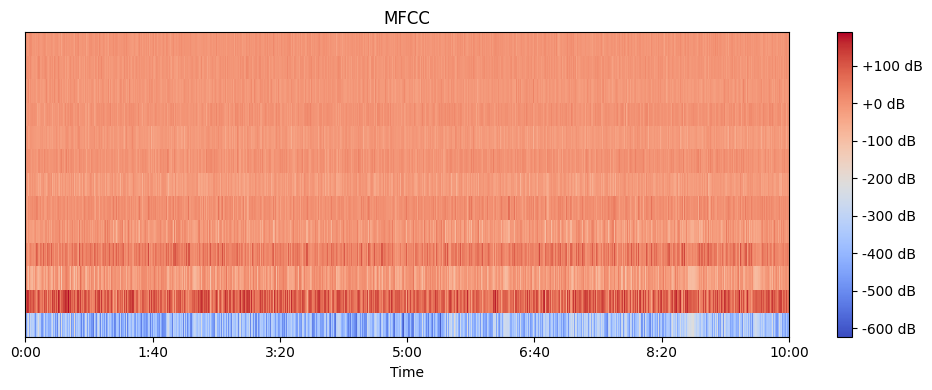

Fake Audio MFCC Graph


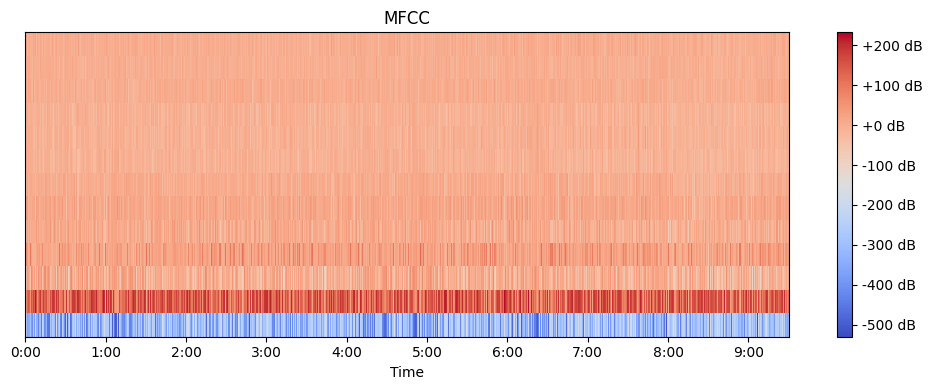

In [8]:
def plot_mfcc(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)  
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='coolwarm') 
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

print('Real Audio MFCC Graph')
plot_mfcc(real_paths[2])  
print('Fake Audio MFCC Graph')
plot_mfcc(fake_paths[2])

In [9]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
checkpoint_callback = ModelCheckpoint(
    'best_deepfake_voice_model.keras',  # Filepath to save the model
    monitor='val_loss',              # Metric to monitor
    verbose=1,                       # Show messages when the model is saved
    save_best_only=True,             # Save only the model with the best validation loss
    mode='min'                       # Minimize the val_loss
)

In [13]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, verbose=1, callbacks=[checkpoint_callback])
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")
    
    return history

In [14]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [15]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8480 - loss: 0.5241
Epoch 1: val_loss improved from inf to 0.41566, saving model to best_deepfake_voice_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8505 - loss: 0.5189 - val_accuracy: 0.8710 - val_loss: 0.4157
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8789 - loss: 0.4128
Epoch 2: val_loss improved from 0.41566 to 0.36773, saving model to best_deepfake_voice_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8801 - loss: 0.4109 - val_accuracy: 0.8710 - val_loss: 0.3677
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8919 - loss: 0.3626
Epoch 3: val_loss improved from 0.36773 to 0.35631, saving model to best_deepfake_voice_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8906 - loss: 0.3642 - val_accuracy: 0.8710 - val_loss: 0.3563
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8919 - loss: 0.3593
Epoch 4: val_loss did not improve from 0.

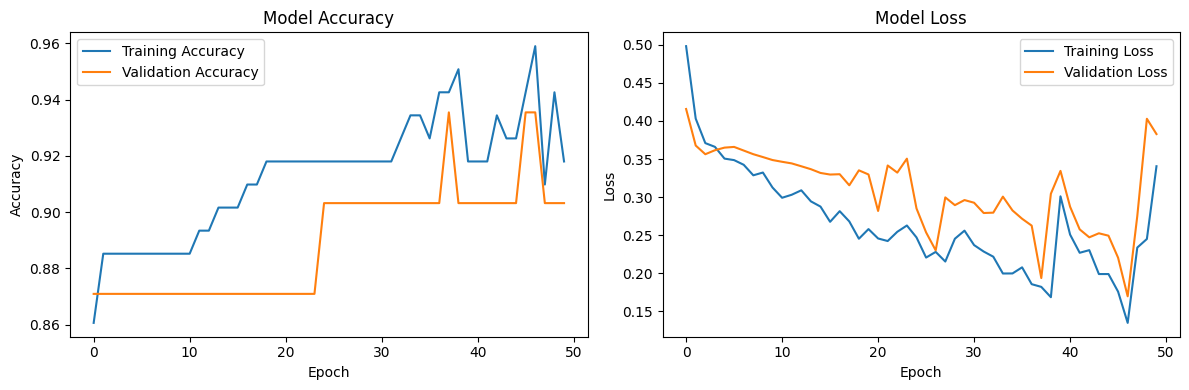

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


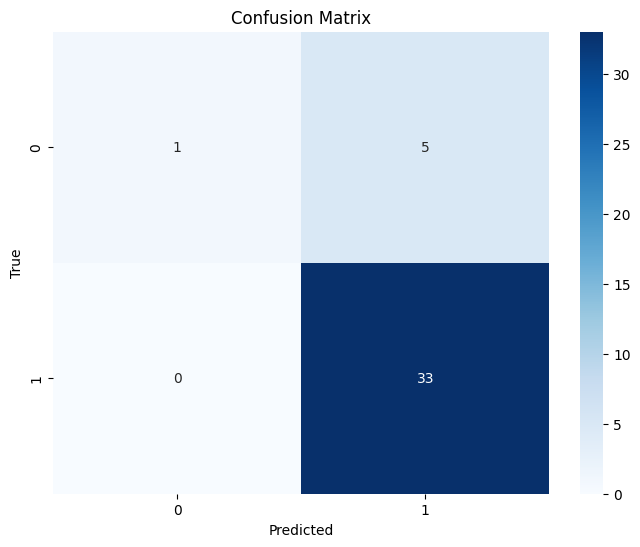

              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.87      1.00      0.93        33

    accuracy                           0.87        39
   macro avg       0.93      0.58      0.61        39
weighted avg       0.89      0.87      0.83        39

Number of real audio samples: 8
Number of fake audio samples: 56
Total number of samples: 64
Shape of padded dataset: (192, 56293, 13)
Maximum sequence length: 56293
Shape of X_train: (153, 56293, 13)
Shape of X_test: (39, 56293, 13)


In [16]:
base_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO"
real_paths = [os.path.join(base_path, "REAL", f) for f in os.listdir(os.path.join(base_path, "REAL")) if f.endswith('.wav')]
fake_paths = [os.path.join(base_path, "FAKE", f) for f in os.listdir(os.path.join(base_path, "FAKE")) if f.endswith('.wav')]

X, y = prepare_dataset(real_paths, fake_paths)
X_augmented, y_augmented = augment_data(X, y)

max_length = max(len(seq) for seq in X_augmented)
X_padded = pad_sequences(X_augmented, maxlen=max_length, dtype='float32', padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_augmented, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = train_and_evaluate(model, X_train, y_train, X_test, y_test)

plot_training_history(history)

y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

print(f"Number of real audio samples: {len(real_paths)}")
print(f"Number of fake audio samples: {len(fake_paths)}")
print(f"Total number of samples: {len(real_paths) + len(fake_paths)}")
print(f"Shape of padded dataset: {X_padded.shape}")
print(f"Maximum sequence length: {max_length}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

In [17]:

def preprocess_audio(audio_path, max_length):
    audio, sr = librosa.load(audio_path, sr=None)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    
    mfccs = mfccs.T
    
    padded_mfccs = pad_sequences([mfccs], maxlen=max_length, dtype='float32', padding='post', truncating='post')
    
    return padded_mfccs



In [18]:
test_audio_paths = ['/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-taylor.wav', '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/biden-original.wav']  # List of audio file paths

for audio_path in test_audio_paths:
    padded_sample = preprocess_audio(audio_path, max_length=X_train.shape[1])
    prediction = model.predict(padded_sample)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    if predicted_class == 1:
        print(f"{audio_path}: Fake")
    else:
        print(f"{audio_path}: Real")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-taylor.wav: Fake
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/biden-original.wav: Real
